# Libraries

In [5]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

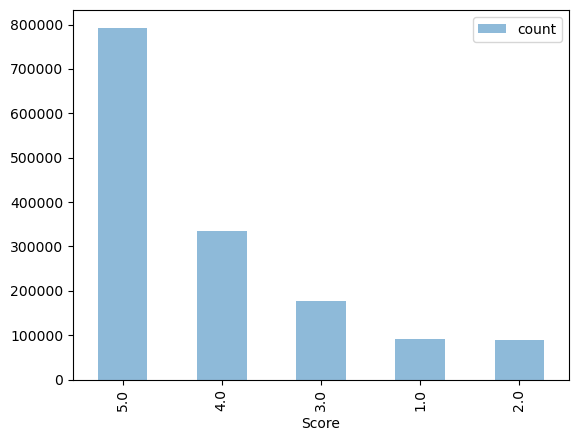


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [9]:
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


# Adding Features

In [34]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Ensure the VADER lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def add_features_to(df):
    print("Adding features to the dataset...")
    # Helpfulness Ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Review Length
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))

    # Sentiment Analysis using VADER
    df['Polarity'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    df['Subjectivity'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['neu'])

    # Summary Length
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(str(x).split()))

    # Number of Exclamation Marks (indicates strong emotion)
    df['ExclamationMarks'] = df['Text'].apply(lambda x: str(x).count('!'))

    # Number of Question Marks (might indicate confusion or negative sentiment)
    df['QuestionMarks'] = df['Text'].apply(lambda x: str(x).count('?'))

    # Average Word Length
    df['AvgWordLength'] = df['Text'].apply(lambda x: sum(len(word) for word in str(x).split()) / (len(str(x).split()) + 1))

    # Review Year
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year

    print("Feature engineering completed.")
    return df

# Ensure the 'data' directory exists
if not os.path.exists('./data'):
    os.makedirs('./data')
    print("Created 'data' directory.")

# Force feature extraction regardless of existing files
print("Skipping loading existing files and proceeding with feature extraction...")

# For testing purposes, process a smaller batch of data (e.g., 20,000 rows)
print("Sampling 20,000 rows from the training dataset...")
sample_train = trainingSet.sample(20000, random_state=42)  # Adjust the number as needed
print("Processing a smaller batch of 20,000 rows for testing.")

# Apply feature engineering to the smaller batch
sample_train = add_features_to(sample_train)

# Merge the smaller processed batch with testingSet on Id
print("Merging the sample training data with the testing set...")
X_submission = pd.merge(testingSet, sample_train, on='Id', how='left')
print("Merge completed. Filling any missing values...")
X_submission = X_submission.drop(columns=['Score_x'], errors='ignore')
X_submission = X_submission.rename(columns={'Score_y': 'Score'})
X_submission = X_submission.fillna(0)

# The training set is where the score is not null
print("Extracting non-null score data from the sample training data...")
X_train = sample_train[sample_train['Score'].notnull()]

# Save the processed data
print("Saving the processed data...")
X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)
print("Feature extraction complete and files saved.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mahekhemani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Skipping loading existing files and proceeding with feature extraction...
Sampling 20,000 rows from the training dataset...
Processing a smaller batch of 20,000 rows for testing.
Adding features to the dataset...
Feature engineering completed.
Merging the sample training data with the testing set...
Merge completed. Filling any missing values...
Extracting non-null score data from the sample training data...
Saving the processed data...
Feature extraction complete and files saved.


# Sample + Split into training and testing set

In [35]:
from sklearn.model_selection import train_test_split

# Define the features that will be used for training
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 
            'ReviewLength', 'Polarity', 'Subjectivity', 'SummaryLength', 'ReviewYear']

# Select the features from the X_train dataset
X = X_train[features]  # Feature set
Y = X_train['Score']   # Target variable (labels)

# Split the dataset into training and testing sets (75% training, 25% testing)
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(
    X, Y,
    test_size=0.25,     # 25% of the data will be used as the test set
    random_state=42     # Random seed for reproducibility
)

# Display the shapes of the splits to confirm
print("X_train_split shape:", X_train_split.shape)
print("X_test_split shape:", X_test_split.shape)
print("Y_train_split shape:", Y_train_split.shape)
print("Y_test_split shape:", Y_test_split.shape)


X_train_split shape: (13126, 9)
X_test_split shape: (4376, 9)
Y_train_split shape: (13126,)
Y_test_split shape: (4376,)


# Feature Selection

In [36]:
# Define the features to be selected
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 
            'ReviewLength', 'Polarity', 'Subjectivity', 'SummaryLength', 'ReviewYear']

# Select these features from the training, testing, and submission datasets
X_train_select = X_train_split[features]
X_test_select = X_test_split[features]
X_submission_select = X_submission[features]

# Display the shapes of the newly created datasets to verify
print("X_train_select shape:", X_train_select.shape)
print("X_test_select shape:", X_test_select.shape)
print("X_submission_select shape:", X_submission_select.shape)


X_train_select shape: (13126, 9)
X_test_select shape: (4376, 9)
X_submission_select shape: (212192, 9)


In [38]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_select, Y_train_split)

# Get the best model from the grid search
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
Y_test_predictions = best_rf.predict(X_test_select)

# Evaluate the model's performance
accuracy = accuracy_score(Y_test_split, Y_test_predictions)
conf_matrix = confusion_matrix(Y_test_split, Y_test_predictions)
report = classification_report(Y_test_split, Y_test_predictions)

# Display the results
print("Best Model Accuracy:", accuracy)
print("\nBest Model Confusion Matrix:\n", conf_matrix)
print("\nBest Model Classification Report:\n", report)


Best Model Accuracy: 0.5477605118829981

Best Model Confusion Matrix:
 [[ 126   11   10   11  104]
 [  56   12   16    6  165]
 [  31    7    7   31  462]
 [  13    9    2   41  957]
 [  27    8    7   46 2211]]

Best Model Classification Report:
               precision    recall  f1-score   support

         1.0       0.50      0.48      0.49       262
         2.0       0.26      0.05      0.08       255
         3.0       0.17      0.01      0.02       538
         4.0       0.30      0.04      0.07      1022
         5.0       0.57      0.96      0.71      2299

    accuracy                           0.55      4376
   macro avg       0.36      0.31      0.28      4376
weighted avg       0.43      0.55      0.43      4376



# Model Creation

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)
model.fit(X_train_select, Y_train_split)

# Predict the score using the model on the test set
Y_test_predictions = model.predict(X_test_select)

# Evaluate the model's performance
accuracy = accuracy_score(Y_test_split, Y_test_predictions)
conf_matrix = confusion_matrix(Y_test_split, Y_test_predictions)
report = classification_report(Y_test_split, Y_test_predictions)

# Display the results
print("Model Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


Model Accuracy: 0.529707495429616

Confusion Matrix:
 [[ 111   24   26   14   87]
 [  51   29   23   23  129]
 [  32   19   34   82  371]
 [  15   16   38  141  812]
 [  32   21   47  196 2003]]

Classification Report:
               precision    recall  f1-score   support

         1.0       0.46      0.42      0.44       262
         2.0       0.27      0.11      0.16       255
         3.0       0.20      0.06      0.10       538
         4.0       0.31      0.14      0.19      1022
         5.0       0.59      0.87      0.70      2299

    accuracy                           0.53      4376
   macro avg       0.37      0.32      0.32      4376
weighted avg       0.45      0.53      0.46      4376



# Model Evaluation

Accuracy on testing set = 0.35351919561243145


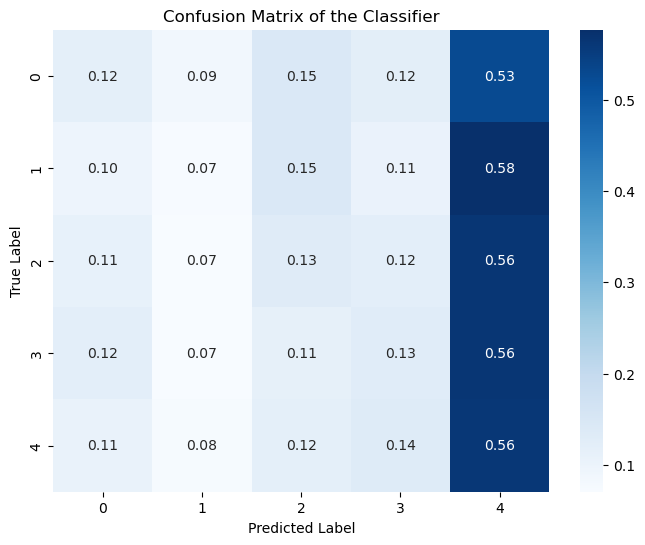

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model's accuracy on the testing set
accuracy = accuracy_score(Y_test_split, Y_test_predictions)
print("Accuracy on testing set =", accuracy)

# Plot a confusion matrix
cm = confusion_matrix(Y_test_split, Y_test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Create submission file

In [40]:
# Predict the scores for the submission dataset using the best model
X_submission['Score'] = best_rf.predict(X_submission_select)

# Select only the 'Id' and 'Score' columns for the submission file
submission = X_submission[['Id', 'Score']]

# Save the submission file in the required format
submission.to_csv("./data/submission.csv", index=False)

print("Submission file created successfully! Number of rows:", submission.shape[0])


Submission file created successfully! Number of rows: 212192
